In [1]:
from scipy.sparse.linalg import splu, factorized
from scipy.linalg import lu_factor, lu_solve
import numpy as np
np.set_printoptions(precision=4) # Print few decimal places
np.set_printoptions(suppress=True) # Suppress scientific notation
import cvxpy as cp
import pandas as pd
from numpy.linalg import cholesky as llt
import matplotlib.pyplot as plt
import scipy.stats as stats
import time
import pulp
import gurobipy as gp
import scipy.io
from scipy.sparse import csc_matrix
np.set_printoptions(threshold=np.inf, linewidth=200)

Importing problems from Netlib LP

Problem is in format of:

min $c^T x$

s.t. $Ax = b$

$x\geq0$

We change it to:

min $c^T x$

s.t. $\bar{A}x+s = b$

$s \in C$

where $C = \{0\}^{n_{eq}} \times \mathbb{R}_+^{ineq}$, $x \in \mathbb{R}$, and $\bar{A} = [A, -I]$

Importing Data

In [2]:
# NOTE
# We do not use the lower and upper bounds given in the problem data, instead we just use the x >= 0 as our bounds


# Sublinear in both ADMM and Restart ADMM
prob_fail = ['ADLITTLE', 'AGG', 'BRANDY', 'CAPRI', 'E226', 'ISRAEL', 'LOTFI', 'BEACONFD']
# Large problem didn't test
prob_large = ['QAP15', 'QAP8', '25FV47']
# Sublinear in ADMM but linear with Restarts
prob_success = ['BLEND']
# All Problems tested
prob_test = ['ADLITTLE', 'QAP8', '25FV47', 'AGG', 'BRANDY', 'CAPRI', 'E226', 'ISRAEL', 'LOTFI', 
             'BLEND', 'BEACONFD']

k = 0

mat_data = scipy.io.loadmat(f"C:/Users/baice/Desktop/Junior Year 2nd Sem/ORF 498/LP Problems/{prob_test[k]}.mat")

A_mat = mat_data['A'].toarray()
b_mat = mat_data['b'].flatten()
c_mat = mat_data['c'].flatten()


x = cp.Variable(A_mat.shape[1])
objective = cp.Minimize(c_mat.T @ x)
constraints = [A_mat @ x == b_mat, x >= 0]
problem = cp.Problem(objective, constraints)
problem.solve(solver = cp.SCIPY)

print(f"Problem {prob_test[k]}")
print("obj =", objective.value)

Problem ADLITTLE
obj = 225494.9631623803


In [3]:
def plot_results(ADMM, ADMM_custom, label_custom):
    fig, ax = plt.subplots(1, 5, figsize=(20,5), constrained_layout=True)
    
    ax[0].plot(ADMM[0], label='ADMM')
    ax[0].set_yscale('log')
    ax[0].set_ylabel('Dual Residual')
    ax[0].set_xlabel('Iteration')

    ax[1].plot(ADMM[1], label='ADMM')
    ax[1].set_yscale('log')
    ax[1].set_ylabel('Primal Residual')
    ax[1].set_xlabel('Iteration')

    ax[2].plot(ADMM[2], label='ADMM')
    ax[2].set_yscale('log')
    ax[2].set_ylabel('Duality Gap')
    ax[2].set_xlabel('Iteration')

    ax[3].plot(ADMM[3], label='ADMM')
    ax[3].set_yscale('log')
    ax[3].set_ylabel('KKT Value')
    ax[3].set_xlabel('Iteration')

    ax[4].plot(ADMM[4], label='ADMM')
    ax[4].set_yscale('log')
    ax[4].set_ylabel('ADMM value - optimal')
    ax[4].set_xlabel('Iteration')
    
    
    
    ax[0].plot(ADMM_custom[0], label=label_custom)

    ax[1].plot(ADMM_custom[1], label=label_custom)

    ax[2].plot(ADMM_custom[2], label=label_custom)

    ax[3].plot(ADMM_custom[3], label=label_custom)

    ax[4].plot(ADMM_custom[4], label=label_custom)
    
    
    
    # Plot against a linear convergence
    k_value = np.arange(0, len(ADMM[0]), 1)
    y_value = (0.997) ** k_value
    ax[0].plot(y_value, label=r"$y=0.997^k$", linewidth=2.5)

    y_value = (0.995) ** k_value
    ax[1].plot(y_value, label=r"$y=0.995^k$", linewidth=2.5)

    y_value = (0.997) ** k_value
    ax[2].plot(y_value, label=r"$y=0.997^k$", linewidth=2.5)
    ax[3].plot(y_value, label=r"$y=0.995^k$", linewidth=2.5)
    ax[4].plot(y_value, label=r"$y=0.997^k$", linewidth=2.5)
    
    
    # Plot against a sublinear convergence
    k_value = np.arange(0, len(ADMM[0]), 1)
    y_value = 1 / k_value

    ax[0].plot(y_value, label=r"$y=1/k$", linewidth=2.5)
    ax[0].legend()

    ax[1].plot(y_value, label=r"$y=1/k$", linewidth=2.5)
    ax[1].legend()

    ax[2].plot(y_value, label=r"$y=1/k$", linewidth=2.5)
    ax[2].legend()

    ax[3].plot(y_value, label=r"$y=1/k$", linewidth=2.5)
    ax[3].legend()

    ax[4].plot(y_value, label=r"$y=1/k$", linewidth=2.5)
    ax[4].legend()
    
    return

New KKT as only positive constraint

In [4]:
def KKT_error_new_mat(w, c, A, b, x, s, y, m, n):
    temp = A@x
    temp = temp + s
    temp = temp - b
    norm1 = np.linalg.norm(A@x + s - b, 2) ** 2
    
    # Normal dual residual
    b_matrix = np.vstack([np.zeros((m, n)), np.eye(n)])

    # Adjusted due to the reformulation of the problem
    norm2 = np.linalg.norm(np.minimum(c - (A.T+b_matrix.T) @ y, 0)) ** 2
    
    KKT = np.sqrt(w**2 * norm1 + (1/(w**2)) * norm2 + (b.T@y - c.T@x) ** 2)
    
    return KKT

ADMM:
$$x^{k+1} = argmin_x \{c^Tx + (\rho / 2)||Ax+s^k-b - (1/\rho)y^k||_2^2 \}$$

$$s^{k+1} = argmin_{\{s\in C\}} \{(\rho/2)||Ax^{k+1} + s - b - (1/\rho)y^k||_2^2\}$$

$$y^{k+1} = y^k - \rho (Ax^{k+1} + s^{k+1} -b)$$

$$\hat{y}^{k+1} = y^k - \rho (Ax^{k+1} + s^{k} -b)$$

Closed Form (if A has full column rank):

$$x^{k+1} = (A^T A) ^{-1} (-(1/\rho)c - A^T (s^k - b - (1/\rho) y^k))$$

$$s^{k+1} = proj_{\bold{C}}(-(Ax^{k+1} -b - (1/\rho) y^k) ) $$

The projection step is setting the $n_{eq}$ to 0 and clipping the negative of the others

In [5]:
# If using LU Factorization
def ADMM_new_mat(c, A, b, x, s, y, rho, n, m, lu):   
# If using QR Factorization
# def ADMM_new_mat(c, A, b, x, s, y, rho, n, m, Q, R):

    # CVXPY
    
    # var1 = cp.Variable(x.shape[0])
    # constraint1 = []
    # objective = cp.Minimize(c.T@var1 + (rho/2)*cp.sum_squares(A@var1+s-b-(1/rho)*y))
    # prob1 = cp.Problem(objective, constraint1)
    # prob1.solve()
    # x_next = var1.value
    
    # var2 = cp.Variable(s.shape[0])
    # constraint2 = [var2[:m] == 0, var2[m:] >= 0]
    # objective = cp.Minimize((rho/2)*cp.sum_squares(A@x_next + var2 - b - (1/rho)*y))
    # prob2 = cp.Problem(objective, constraint2)
    # prob2.solve()
    # s_next = var2.value
    
    
    # Closed Form
    
    # LU Factorization
    d = -(1/rho) * c - A.T @ (s - b - (1/rho) * y)
    x_next = lu.solve(d)
    
    # Just solving the linear system
    # x_next = np.linalg.solve(A.T @ A, d)
    
    # QR Factorization
    # x_next = np.dot(Q.T, d)
    # x_next = np.linalg.solve(R, x_next)
    
    s_next = np.zeros(s.shape[0])
    term = -(A @ x_next - b - (1/rho) * y)
    # for i in range(len(s_next[m:])):
    #     s_next[i+m] = max(0, term[i+m])
    # I think the one below faster
    s_next[m:] = np.clip(term[m:], 0, None)
    
        
    
    y_next = y - rho*(A@x_next + s_next - b)
    y_hat_next = y - rho*(A@x_next + s - b)
    
    z_hat_next = [x_next, s_next, y_hat_next]
    z_next = [x_next, s_next, y_next]
    
    return z_hat_next, z_next

$L(x,s,y) = c^T + y^T b - y^T A x - y^T s$

In [6]:
def normalized_duality_gap(c, x, s, y, b, A, r, m):
    x1 = cp.Variable(x.shape)
    y1 = cp.Variable(y.shape)
    s1 = cp.Variable(s.shape)
    
    objective = cp.Maximize(c.T @ x + y1.T @ b - y1.T @ A @ x - y1.T @ s - (c.T @ x1 + y.T @ b - y.T @ A @ x1 - y.T @ s1))
    constraints = [cp.norm(cp.hstack([x - x1, s - s1, y - y1]), 2) <= r, s1[:m] == 0, s1[m:] >= 0]
    
    problem = cp.Problem(objective, constraints)
    
    # Sometimes the solvers fail
    lp_solvers = ['CLARABEL', 'SCIPY', 'CVXOPT', 'ECOS', 'GUROBI', 'OSQP', 'GLPK']
    for solver in lp_solvers:
        try:
            problem.solve(solver=solver, tol_gap_abs=1e-8, tol_gap_rel=1e-8,tol_feas=1e-8, tol_ktratio=1e-8)
            if problem.status in ['optimal', 'infeasible','unbounded']:
                break
        except Exception as e:
            print(f"Solver {solver} failed. ErrorL {e}")
    
    return problem.value / r

ADMM

Did cvxpy converge = True
cvxpy value = 225494.9631685411
A.T @ A is invertible True


C:\Users\baice\AppData\Local\Temp\ipykernel_56832\1578340276.py:42: SparseEfficiencyWarning: splu converted its input to CSC format
  lu = splu(A.T @ A)


ADMM value = 224732.47930948742


C:\Users\baice\AppData\Local\Temp\ipykernel_56832\600647710.py:59: RuntimeWarning: divide by zero encountered in divide
  y_value = 1 / k_value


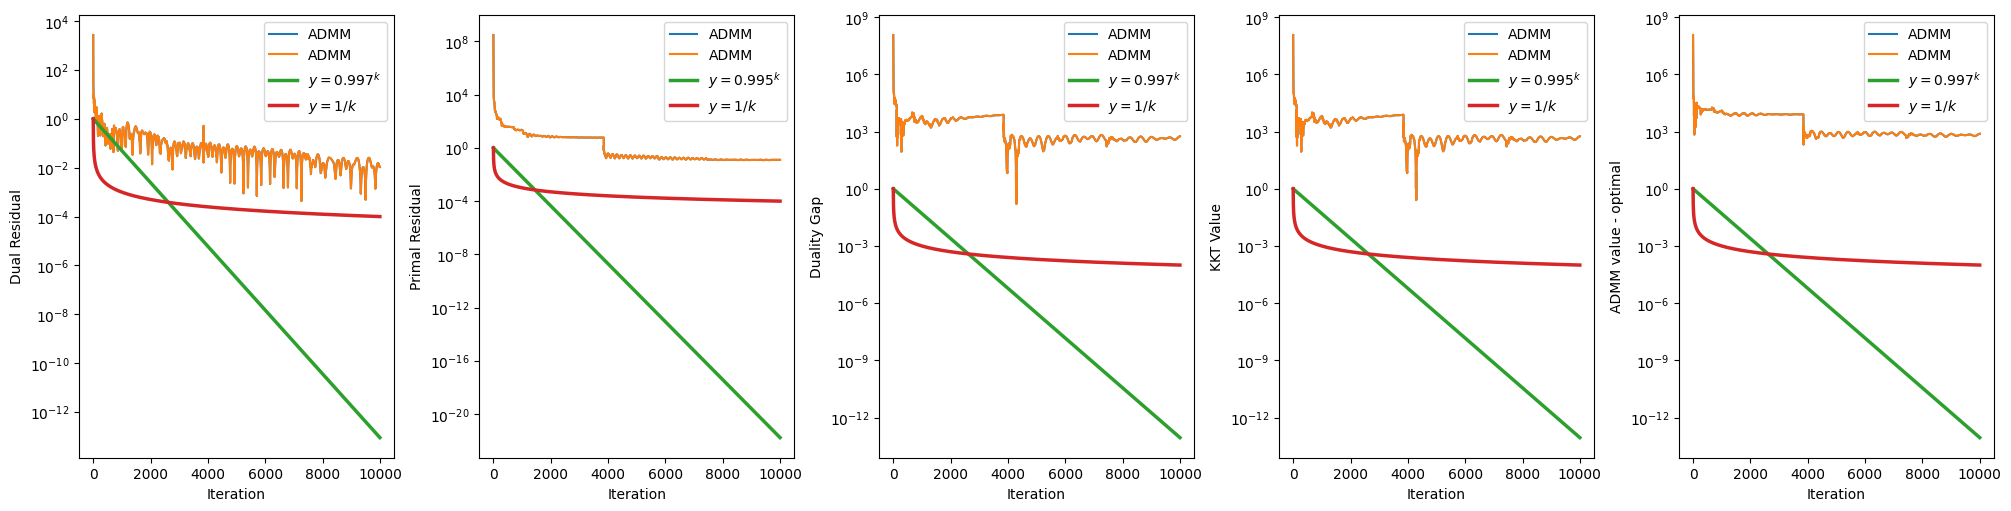

In [7]:
# NOTE
# ADMM

np.random.seed(142)

KKT_valus = []
duality_gap = []
primal_residual = []
dual_residual = []

n = A_mat.shape[1]
m = A_mat.shape[0]

# Addign slack variables
A = np.vstack([A_mat, -np.eye(n)])

b = np.hstack([b_mat, np.zeros(n)])

c = c_mat

iterations = 10000

x = np.zeros(n)
s = np.zeros(b.shape[0])
y = np.zeros(b.shape[0])
# NOTE Not sure if rho is the right value, just choose an argibrary one
rho = 0.3

# Implementing CVXPY to get the optimal values
x_cvxpy = cp.Variable(n)
s_cvxpy = cp.Variable(b.shape[0])
objective = cp.Minimize(c.T@x_cvxpy)
constraints = [A@x_cvxpy + s_cvxpy == b, s_cvxpy[m:] >= 0, s_cvxpy[:m] == 0]
problem = cp.Problem(objective, constraints)
problem.solve(solver=cp.CLARABEL, tol_gap_abs=1e-10, tol_gap_rel=1e-10,tol_feas=1e-10, tol_ktratio=1e-10)
print("Did cvxpy converge =", problem.status == "optimal")
print("cvxpy value =", c.T @ x_cvxpy.value)

# If the A matrix has full collumn rank then A.T @ A is invertible
#       Due to our reformulation this is always true
print("A.T @ A is invertible", np.linalg.matrix_rank(A) == A.shape[1])
lu = splu(A.T @ A)
# Q, R = np.linalg.qr(A.T @ A)

value_ADMM = []

for i in range(iterations):
    # For LU Factorization
    z_hat, z = ADMM_new_mat(c, A, b, x, s, y, rho, n, m, lu)
    # For QR Factorization
    # z_hat, z = ADMM_new_mat(c, A, b, x, s, y, rho, n, m, Q, R)
    
    x = np.copy(z[0])
    s = np.copy(z[1])
    y = np.copy(z[2])
    
    value_ADMM.append(abs(c@x - problem.value))
    
    KKT = KKT_error_new_mat(rho, c, A, b, x, s, y, m, n)
    KKT_valus.append(KKT)
    
    # Normal Duality Gap
    duality_gap.append(abs((b.T@y - c.T@x)))
    
    primal_residual.append(np.linalg.norm(A@x + s - b)**2)
    
    # ADMM Dual Residual
    b_matrix = np.vstack([np.zeros((m,n)), np.eye(n)])

    # This is the dual feasibility violation
    dual_residual.append(np.linalg.norm(np.minimum(c-(A.T+b_matrix.T) @ y, 0)))
    
print("ADMM value =", c.T @ x)
ADMM = [dual_residual, primal_residual, duality_gap, KKT_valus, value_ADMM]
plot_results(ADMM, ADMM, f'ADMM')

KKT Restarts

Did cvxpy converge = True
cvxpy value = 225494.9631685411


C:\Users\baice\AppData\Local\Temp\ipykernel_56832\3950887393.py:44: SparseEfficiencyWarning: splu converted its input to CSC format
  lu = splu(A.T @ A)


we go over 10000 iterations
count = 10000
ADMM with restarts value = 224841.453323683


C:\Users\baice\AppData\Local\Temp\ipykernel_56832\600647710.py:59: RuntimeWarning: divide by zero encountered in divide
  y_value = 1 / k_value


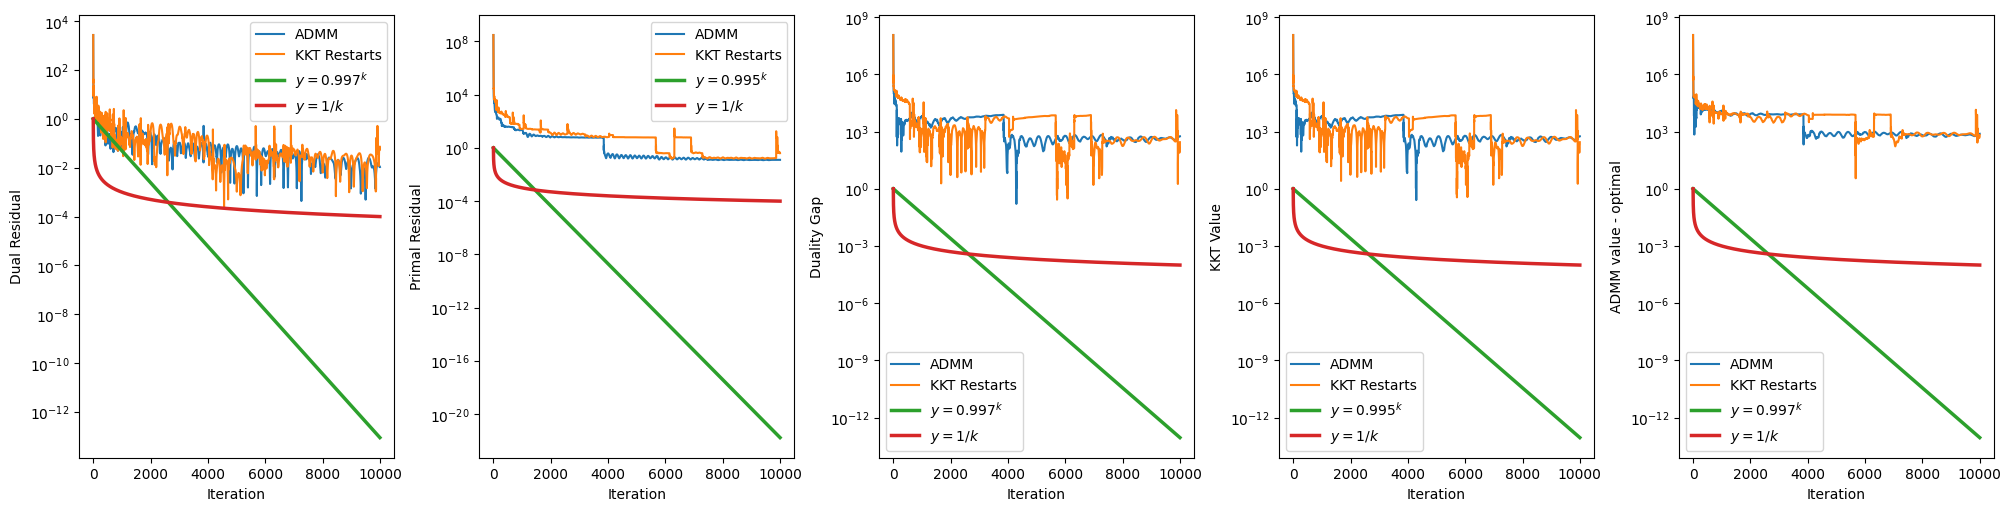

In [8]:
# NOTE
# ADMM + KKT Restarts

np.random.seed(142)

value_ADMM_restarts = []
KKT_valus_rest = []
duality_gap_res = []
primal_residual_rest = []
dual_residual_rest = []

n = A_mat.shape[1]
m = A_mat.shape[0]

# Addign slack variables
A = np.vstack([A_mat, -np.eye(n)])

b = np.hstack([b_mat, np.zeros(n)])

c = c_mat

# Total iterations Number
iterations = 10000

x = np.zeros(n)
s = np.zeros(b.shape[0])
y = np.zeros(b.shape[0])
# NOTE Not sure if nu is the right value, just choose an argibrary one
rho = 0.3

# Implementing CVXPY to get the optimal values
x_cvxpy = cp.Variable(n)
s_cvxpy = cp.Variable(b.shape[0])
objective = cp.Minimize(c.T@x_cvxpy)
constraints = [A@x_cvxpy + s_cvxpy == b, s_cvxpy[m:] >= 0, s_cvxpy[:m] == 0]
problem = cp.Problem(objective, constraints)
problem.solve(solver=cp.CLARABEL, tol_gap_abs=1e-10, tol_gap_rel=1e-10,tol_feas=1e-10, tol_ktratio=1e-10)
print("Did cvxpy converge =", problem.status=='optimal')
print("cvxpy value =", c.T @ x_cvxpy.value)

z = []
z_bar = 0

lu = splu(A.T @ A)

# Initialize values
count = 0
x = np.zeros(n)
s = np.zeros(b.shape[0])
y = np.zeros(b.shape[0])

# Outer loop
for i in range(iterations):
    # Reset values
    z.append(z_bar)
    
    # Reseting the running average
    x_bar = 0
    s_bar = 0
    y_bar = 0
    
    # Set to arbitrary values just so we always start the while loop
    KKT_prev = np.zeros(20, dtype=object)
    KKT_prev[0] = -np.inf
    KKT_prev[1] = -np.inf

    KKT = KKT_error_new_mat(rho, c, A, b, x, s, y, m, n)
    
    KKT_n = -np.inf
    
    # Set to arbitrary values just so we always start the while loop
    KKT_necessary_decay_left_1 = 1
    KKT_necessary_decay_right_1 = 0
    KKT_necessary_decay_left_2 = 0
    KKT_prev_necessary_decay_right_2 = np.array([1, KKT_error_new_mat(rho, c, A, b, x, s, y, m, n)])
    KKT_sufficient_decay_left = 1
    KKT_sufficient_decay_right = 0
    
    t = 0
    
    # Inner loop
    # First while loop is if restart candidate is always the z from ADMM, the second while loop is if we choose the
    #       restart candidate as specified in the research paper
    # while not ((KKT <= 0.8 * KKT_n and KKT > KKT_prev[0]) or (KKT <= 0.2 * KKT_n) or (t >= max(0.36 * count,1))):
    while not ((KKT_necessary_decay_left_1 <= 0.8 * KKT_necessary_decay_right_1 and 
                KKT_necessary_decay_left_2 > KKT_prev_necessary_decay_right_2[0]) or 
               (KKT_sufficient_decay_left <= 0.2 * KKT_sufficient_decay_right) or 
               (t >= max(0.36 * count,1))):
    
        x_prev = x
        
        # ADMM
        z_hat, z_admm = ADMM_new_mat(c, A, b, x, s, y, rho, n, m, lu)
        
        x = z_admm[0]
        s = z_admm[1]
        y = z_admm[2]

        value_ADMM_restarts.append(abs(c@x - problem.value))
        diff = abs(c@x - problem.value)

        x_bar = (t/(1+t)) * x_bar + (1/(1+t)) * z_hat[0]
        s_bar = (t/(1+t)) * s_bar + (1/(1+t)) * z_hat[1]
        y_bar = (t/(1+t)) * y_bar + (1/(1+t)) * z_hat[2]
        
        
        # Choosing the restart candidate
        KKT_normal_z = KKT_error_new_mat(rho, c, A, b, x, s, y, m, n)
        KKT_averaged_z = KKT_error_new_mat(rho, c, A, b, x_bar, s_bar, y_bar, m, n)
        
        if KKT_normal_z < KKT_averaged_z:
            x_cand = x
            s_cand = s
            y_cand = y
        else:
            x_cand = x_bar
            s_cand = s_bar
            y_cand = y_bar
        
        
        KKT = KKT_error_new_mat(rho, c, A, b, x, s, y, m, n)
        KKT_valus_rest.append(KKT)
        
        KKT_sufficient_decay_left = KKT_error_new_mat(rho, c, A, b, x_cand, s_cand, y_cand, m, n)
        
        KKT_necessary_decay_left_1 = np.copy(KKT_sufficient_decay_left)
        KKT_necessary_decay_left_2 = np.copy(KKT_sufficient_decay_left)
        
        
        # Normal Duality Gap
        duality_gap_res.append(abs((b.T@y - c.T@x)))
        
        primal_residual_rest.append(np.linalg.norm(A@x + s - b)**2)
        
        # ADMM Dual Residual
        b_matrix = np.vstack([np.zeros((m,n)), np.eye(n)])

        # This is the dual feasibility violation
        dual_residual_rest.append(np.linalg.norm(np.minimum(c - (A.T+b_matrix.T) @ y, 0)))
        
        
        KKT_prev[0] = np.copy(KKT_prev[1])
        KKT_prev[1] = KKT
        
        KKT_prev_necessary_decay_right_2[0] = np.copy(KKT_prev_necessary_decay_right_2[1])
        KKT_prev_necessary_decay_right_2[1] = np.copy(KKT_sufficient_decay_left)
        
        # Update count
        t += 1
        count += 1
        
        if count >= iterations:
            break
    if count >= iterations:
        print(f"we go over {iterations} iterations")
        break
    
    KKT_n = KKT
    KKT_sufficient_decay_right = KKT_error_new_mat(rho, c, A, b, x_bar, s_bar, y_bar, m, n)
    KKT_necessary_decay_right_1 = np.copy(KKT_sufficient_decay_right)
    x = x_bar
    s = s_bar
    y = y_bar

    z_bar = [x, s, y]

print("count =", count)
print("ADMM with restarts value =", c.T @ x)

ADMM = [dual_residual, primal_residual, duality_gap, KKT_valus, value_ADMM]
ADMM_custom = [dual_residual_rest, primal_residual_rest, duality_gap_res, KKT_valus_rest, value_ADMM_restarts]
plot_results(ADMM, ADMM_custom, 'KKT Restarts')

Adaptive Restarts

Did cvxpy converge = optimal
cvxpy value = 225494.9631685411


C:\Users\baice\AppData\Local\Temp\ipykernel_56832\2197896706.py:44: SparseEfficiencyWarning: splu converted its input to CSC format
  lu = splu(A.T @ A)


we go over 10000 iterations
count = 10000
ADMM with restarts value = 224836.81981160367


C:\Users\baice\AppData\Local\Temp\ipykernel_56832\600647710.py:59: RuntimeWarning: divide by zero encountered in divide
  y_value = 1 / k_value


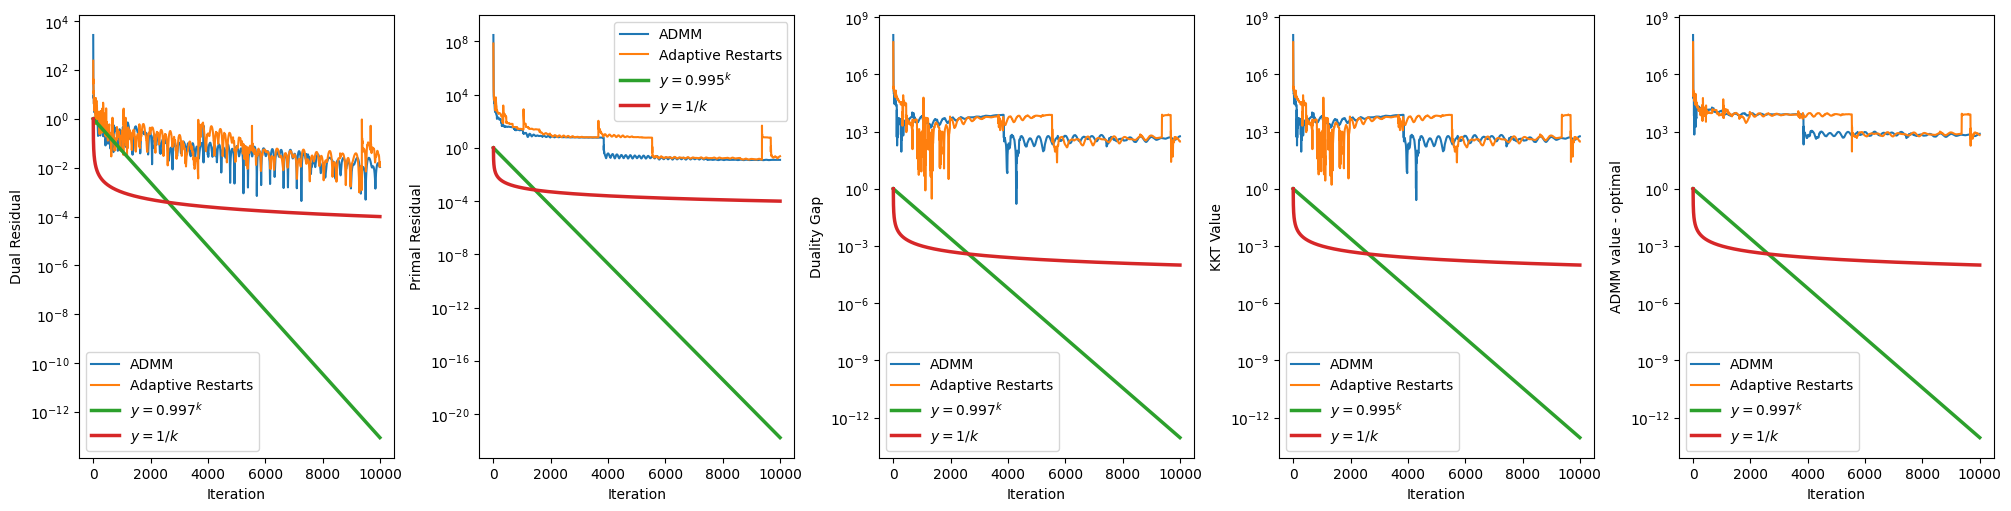

In [9]:
# NOTE
# ADMM + Adaptive Restarts

np.random.seed(142)

value_ADMM_restarts_adap = []
KKT_valus_rest_adap = []
duality_gap_res_adap = []
primal_residual_rest_adap = []
dual_residual_rest_adap = []

n = A_mat.shape[1]
m = A_mat.shape[0]

# Addign slack variables
A = np.vstack([A_mat, -np.eye(n)])

b = np.hstack([b_mat, np.zeros(n)])

c = c_mat

# Total iterations Number
iterations = 10000

x = np.zeros(n)
s = np.zeros(b.shape[0])
y = np.zeros(b.shape[0])
# NOTE Not sure if nu is the right value, just choose an argibrary one
rho = 0.3

# Implementing CVXPY to get the optimal values
x_cvxpy = cp.Variable(n)
s_cvxpy = cp.Variable(b.shape[0])
objective = cp.Minimize(c.T@x_cvxpy)
constraints = [A@x_cvxpy + s_cvxpy == b, s_cvxpy[m:] >= 0, s_cvxpy[:m] == 0]
problem = cp.Problem(objective, constraints)
problem.solve(solver=cp.CLARABEL, tol_gap_abs=1e-10, tol_gap_rel=1e-10,tol_feas=1e-10, tol_ktratio=1e-10)
print("Did cvxpy converge =", problem.status)
print("cvxpy value =", c.T @ x_cvxpy.value)

z = []
z_bar = 0

lu = splu(A.T @ A)
# Not exactly sure what beta should be used
beta = 0.4
# beta = 0.1
# beta = 0.9

# Initialize values
count = 0
x = np.zeros(n)
s = np.zeros(b.shape[0])
y = np.zeros(b.shape[0])

x_0_prev = x
s_0_prev = s
y_0_prev = y


z_hat, z_admm = ADMM_new_mat(c, A, b, x, s, y, rho, n, m, lu)

x = z_admm[0]
s = z_admm[1]
y = z_admm[2]

x_n_0 = x
s_n_0 = s
y_n_0 = y

# Outer loop
for i in range(iterations):
    # Reset values
    z.append(z_bar)
    
    # Reseting the running average
    x_bar = 0
    s_bar = 0
    y_bar = 0
    
    t = 0
    
    # Set to arbitrary values just so we always start the while loop
    left_while_statement = 0
    right_while_statement = 0

    # Inner loop
    while (left_while_statement >= beta * right_while_statement):
        # xv_prev used for KKT
        x_prev = x
        
        # ADMM
        z_hat, z_admm = ADMM_new_mat(c, A, b, x, s, y, rho, n, m, lu)
        
        x = z_admm[0]
        s = z_admm[1]
        y = z_admm[2]

        value_ADMM_restarts_adap.append(abs(c@x - problem.value))
        diff = abs(c@x - problem.value)

        x_bar = (t/(1+t)) * x_bar + (1/(1+t)) * z_hat[0]
        s_bar = (t/(1+t)) * s_bar + (1/(1+t)) * z_hat[1]
        y_bar = (t/(1+t)) * y_bar + (1/(1+t)) * z_hat[2]
        
        KKT = KKT_error_new_mat(rho, c, A, b, x, s, y, m, n)
        KKT_valus_rest_adap.append(KKT)
        
        # Normal Duality Gap
        duality_gap_res_adap.append(abs((b.T@y - c.T@x)))
        
        primal_residual_rest_adap.append(np.linalg.norm(A@x + s - b)**2)
        
        # ADMM Dual Residual
        b_matrix = np.vstack([np.zeros((m,n)), np.eye(n)])

        # This is the dual feasibility violation
        dual_residual_rest_adap.append(np.linalg.norm(np.minimum(c - (A.T+b_matrix.T) @ y, 0)))
        
        # Update count
        t += 1
        count += 1
        
        if count >= iterations:
            break
        
        left_while_statement = normalized_duality_gap(c, x_bar, s_bar, y_bar, b, A, np.linalg.norm(np.hstack([x_bar - x_n_0, s_bar - s_n_0, y_bar - y_n_0]),2), m)
        right_while_statement = normalized_duality_gap(c, x_n_0, s_n_0, y_n_0, b, A, np.linalg.norm(np.hstack([x_n_0 - x_0_prev, s_n_0 - s_0_prev, y_n_0 - y_0_prev]),2), m)
        
    if count >= iterations:
        print(f"we go over {iterations} iterations")
        break

    x = x_bar
    s = s_bar
    y = y_bar
    
    x_0_prev = x_n_0
    s_0_prev = s_n_0
    y_0_prev = y_n_0
    
    x_n_0 = np.copy(x_bar)
    s_n_0 = np.copy(s_bar)
    y_n_0 = np.copy(y_bar)
    
    z_bar = [x, s, y]

print("count =", count)
print("ADMM with restarts value =", c.T @ x)
ADMM = [dual_residual, primal_residual, duality_gap, KKT_valus, value_ADMM]
ADMM_custom = [dual_residual_rest_adap, primal_residual_rest_adap, duality_gap_res_adap, KKT_valus_rest_adap, value_ADMM_restarts_adap]
plot_results(ADMM, ADMM_custom, f'Adaptive Restarts')

Fixed Frequency Restarts

Did cvxpy converge = optimal
cvxpy value = 225494.9631685411


C:\Users\baice\AppData\Local\Temp\ipykernel_56832\495459161.py:47: SparseEfficiencyWarning: splu converted its input to CSC format
  lu = splu(A.T @ A)


For f = 25 we go over 10000 iterations


C:\Users\baice\AppData\Local\Temp\ipykernel_56832\600647710.py:59: RuntimeWarning: divide by zero encountered in divide
  y_value = 1 / k_value


For f = 50 we go over 10000 iterations
For f = 100 we go over 10000 iterations
For f = 150 we go over 10000 iterations
For f = 200 we go over 10000 iterations
For f = 400 we go over 10000 iterations
For f = 800 we go over 10000 iterations
For f = 1000 we go over 10000 iterations
For f = 1500 we go over 10000 iterations
For f = 2000 we go over 10000 iterations
For f = 2500 we go over 10000 iterations
count = 10000
ADMM with restarts value = 224695.7092805494


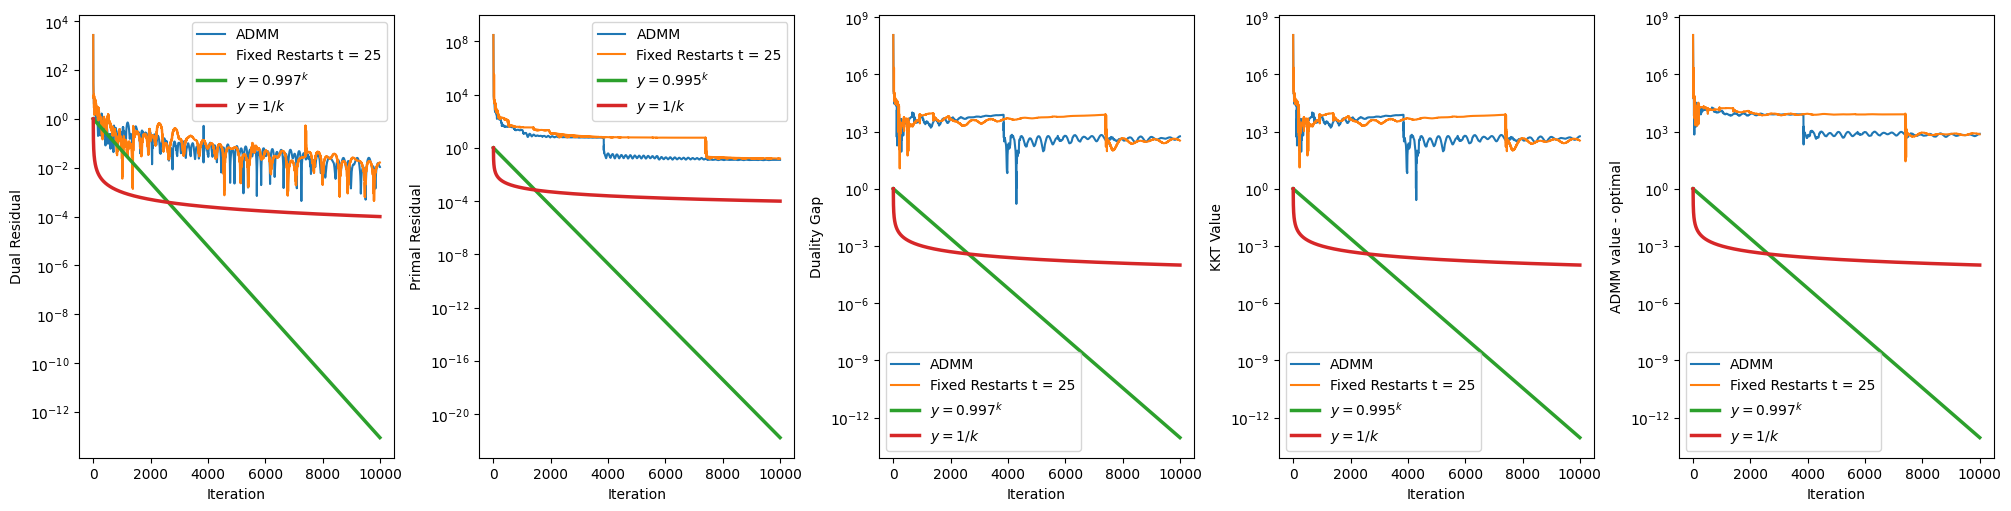

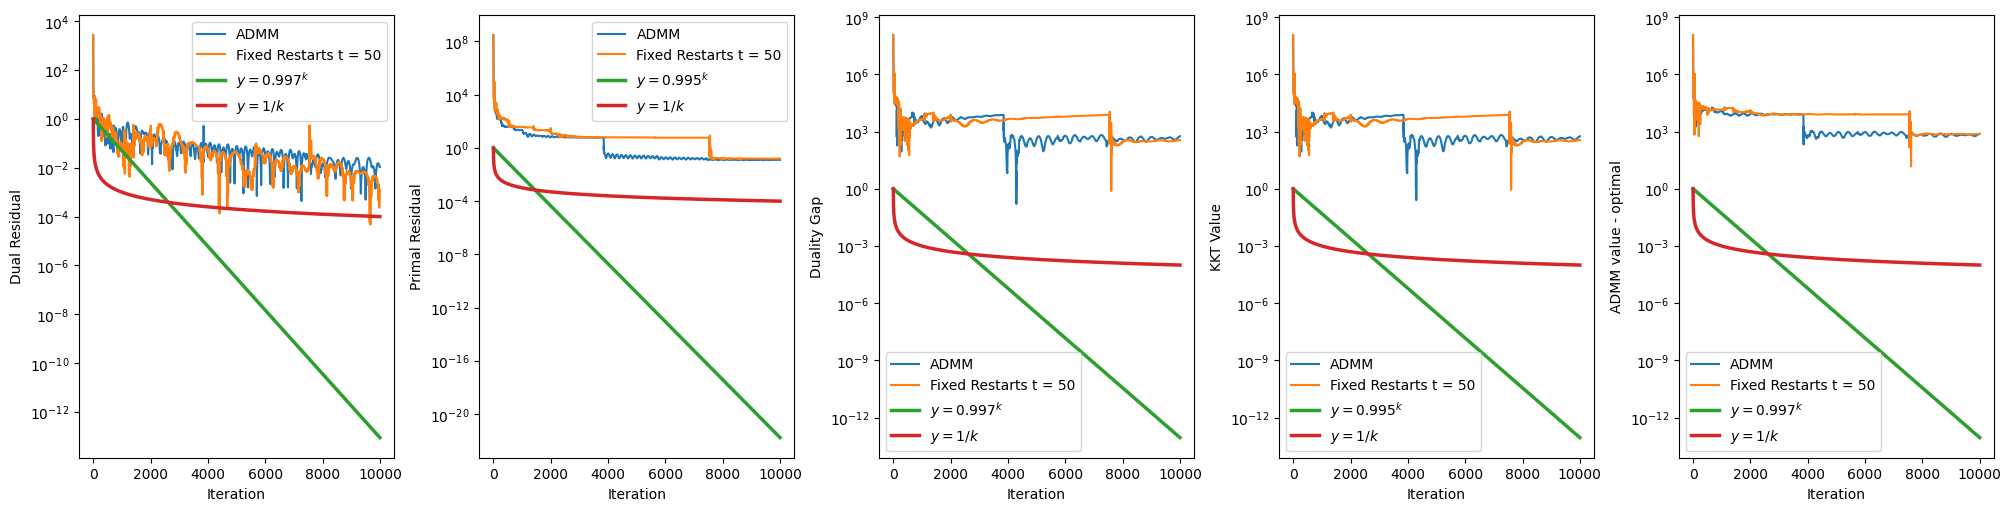

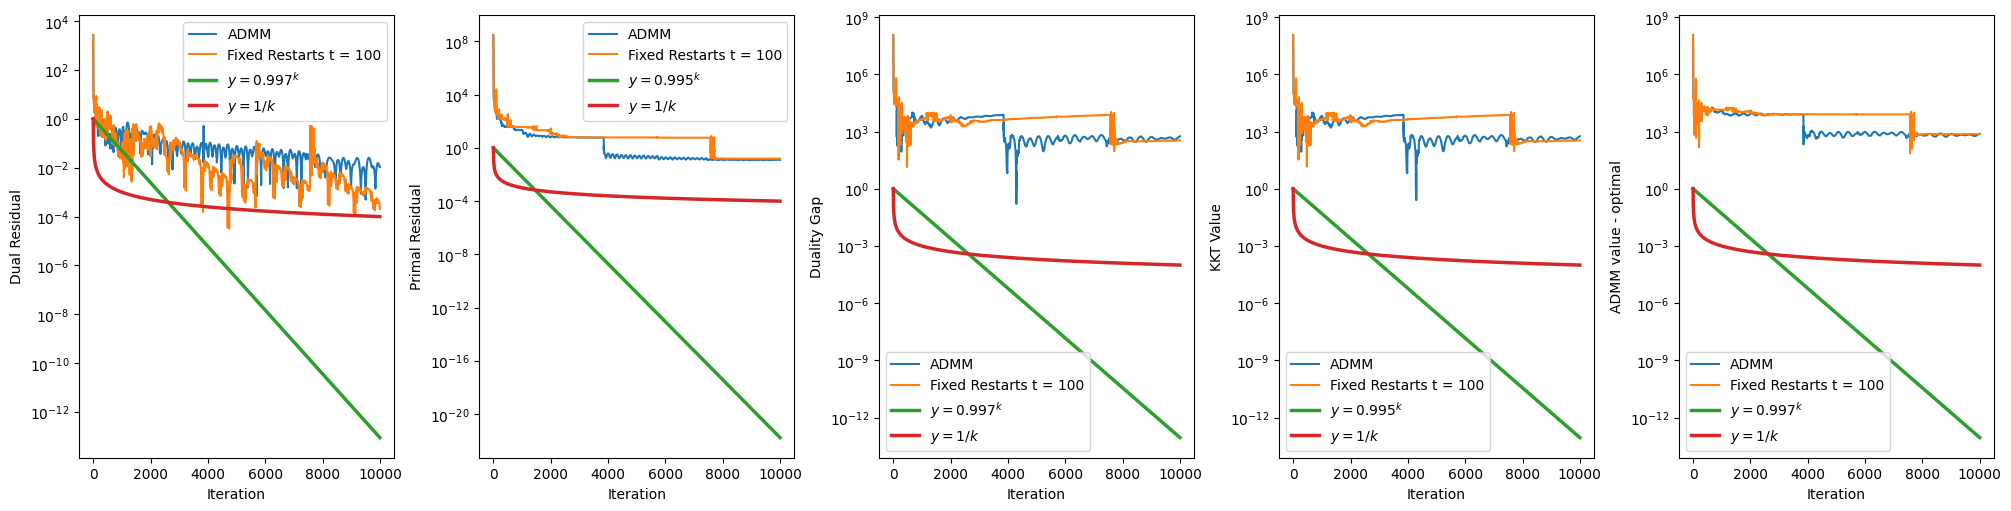

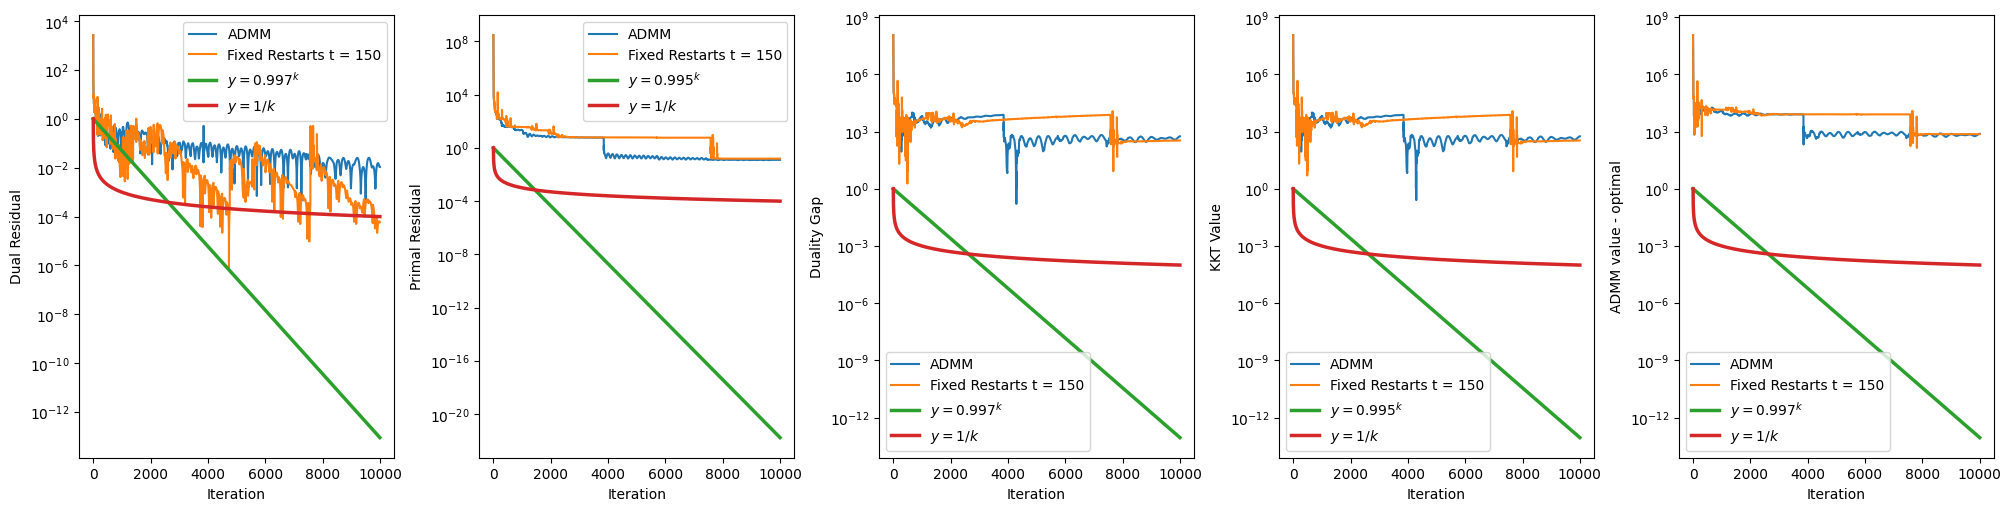

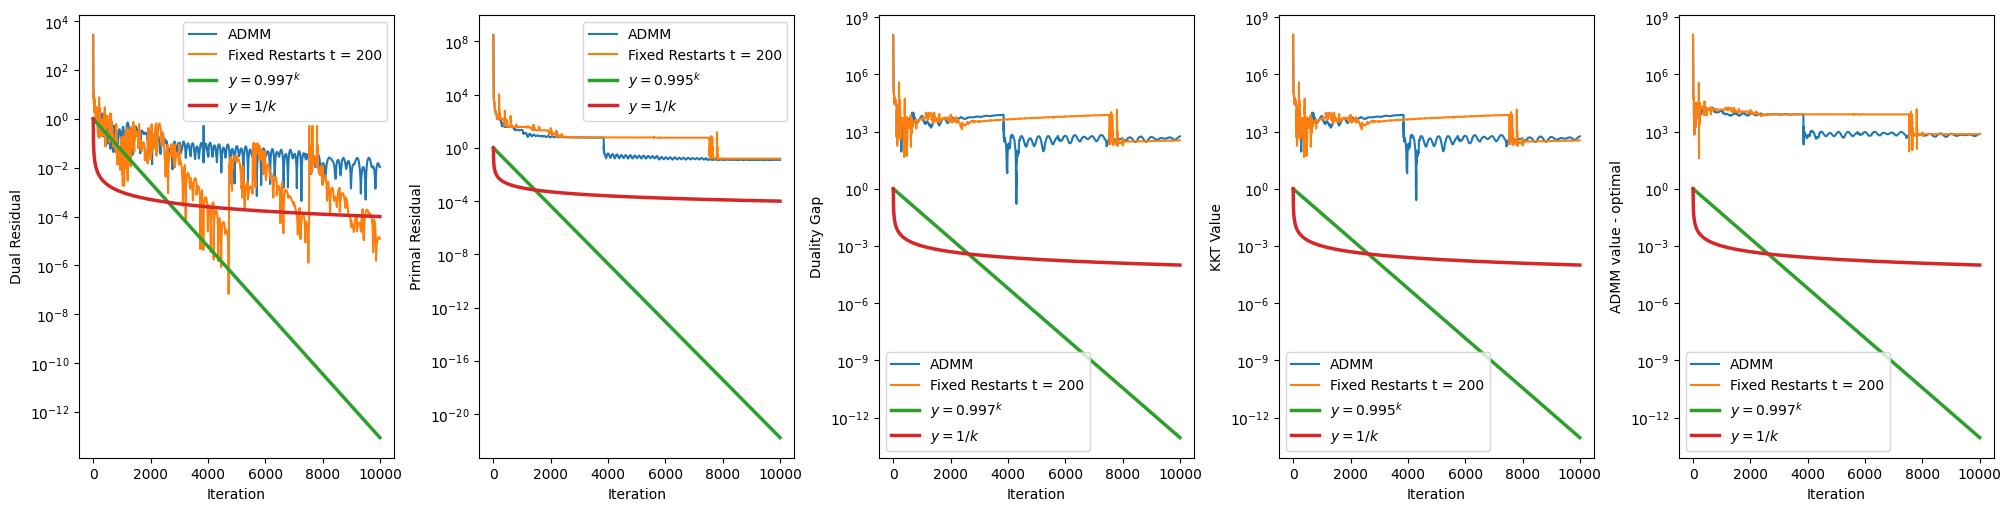

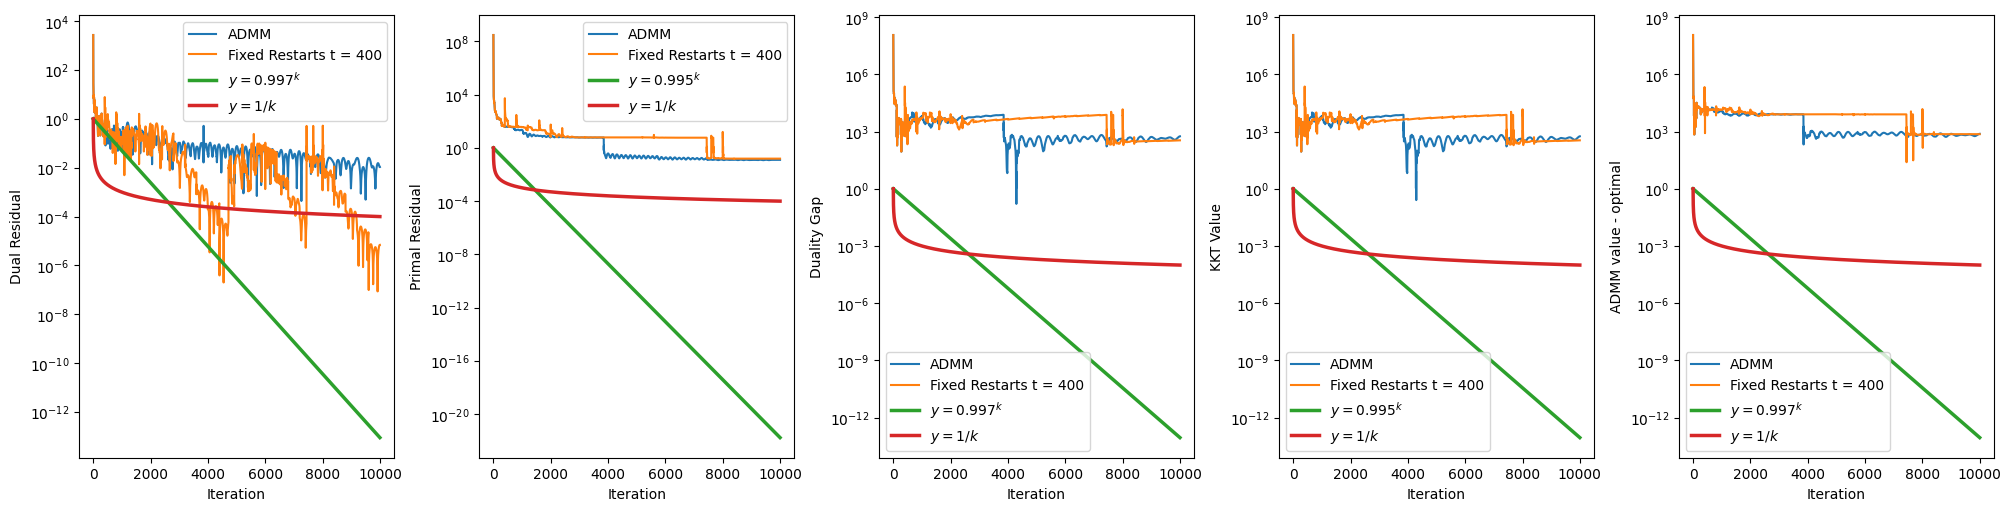

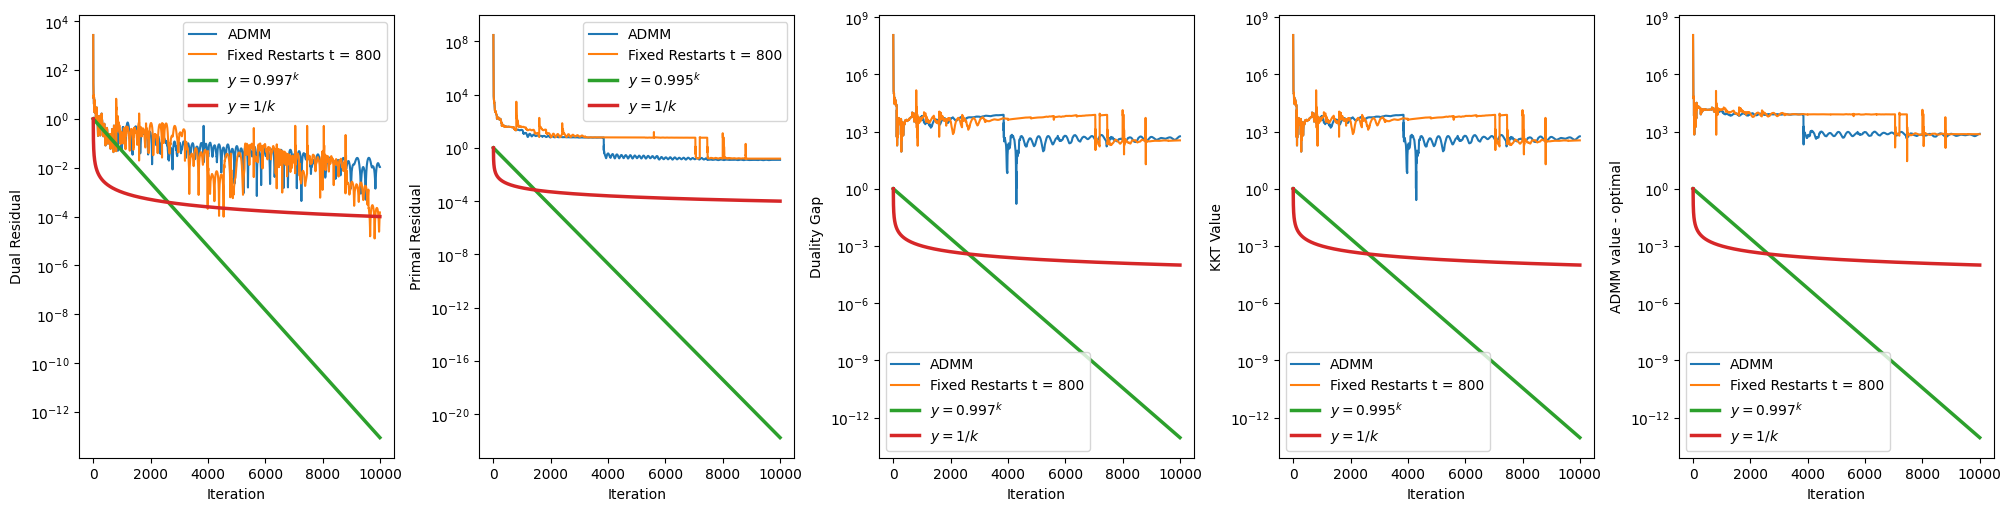

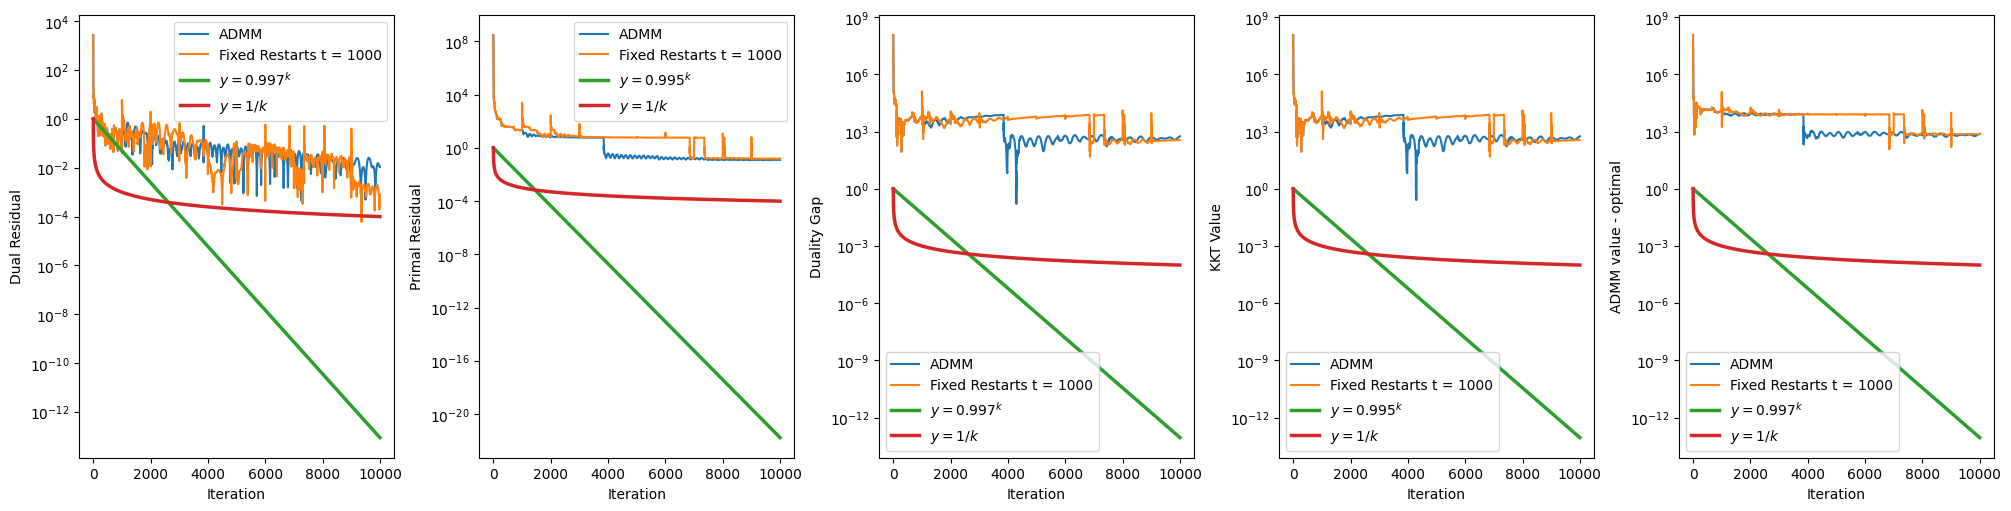

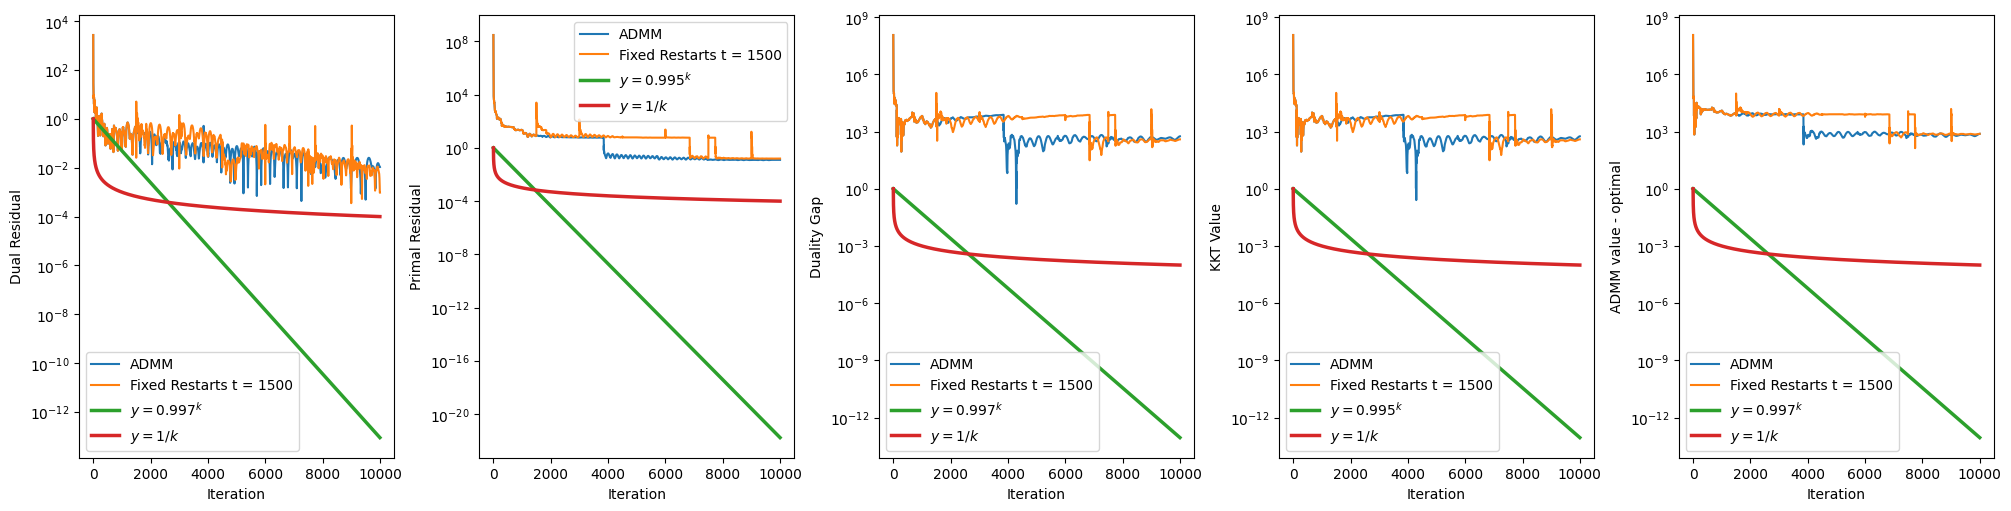

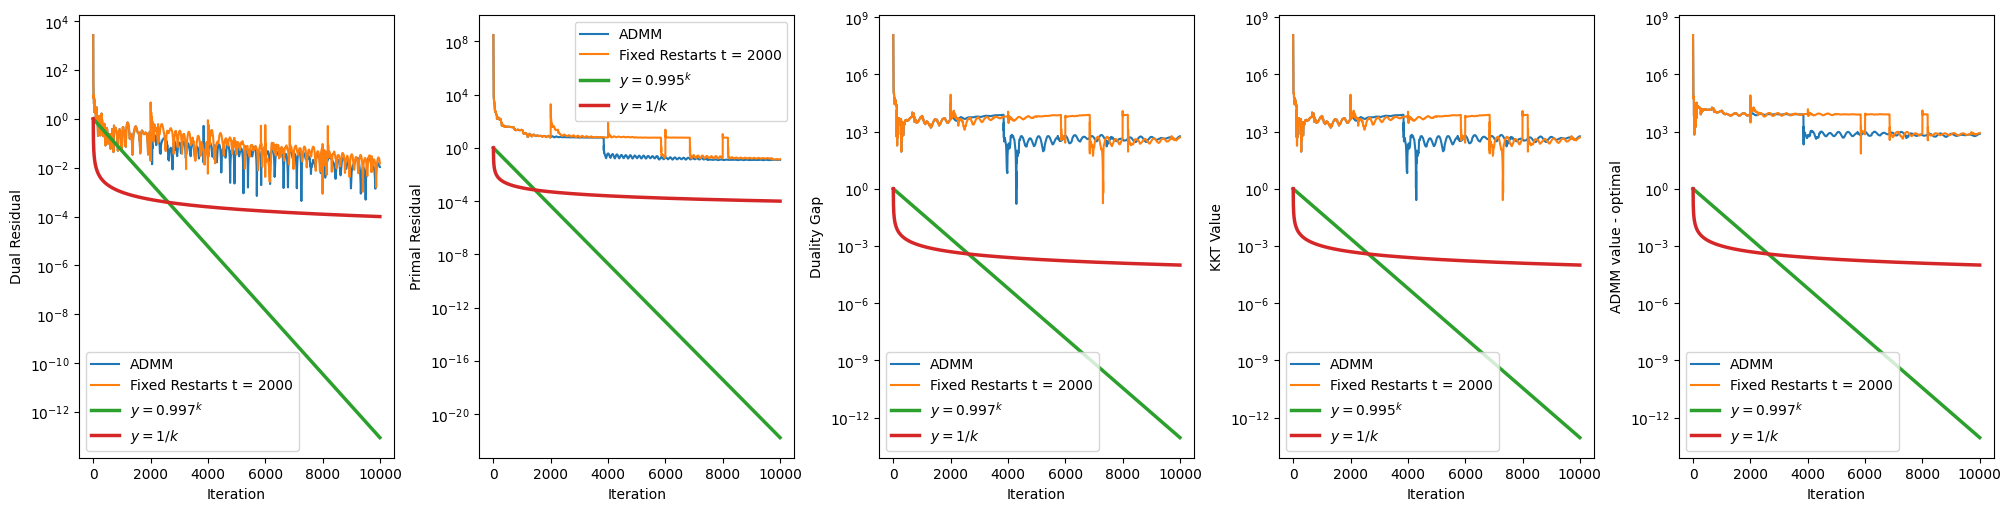

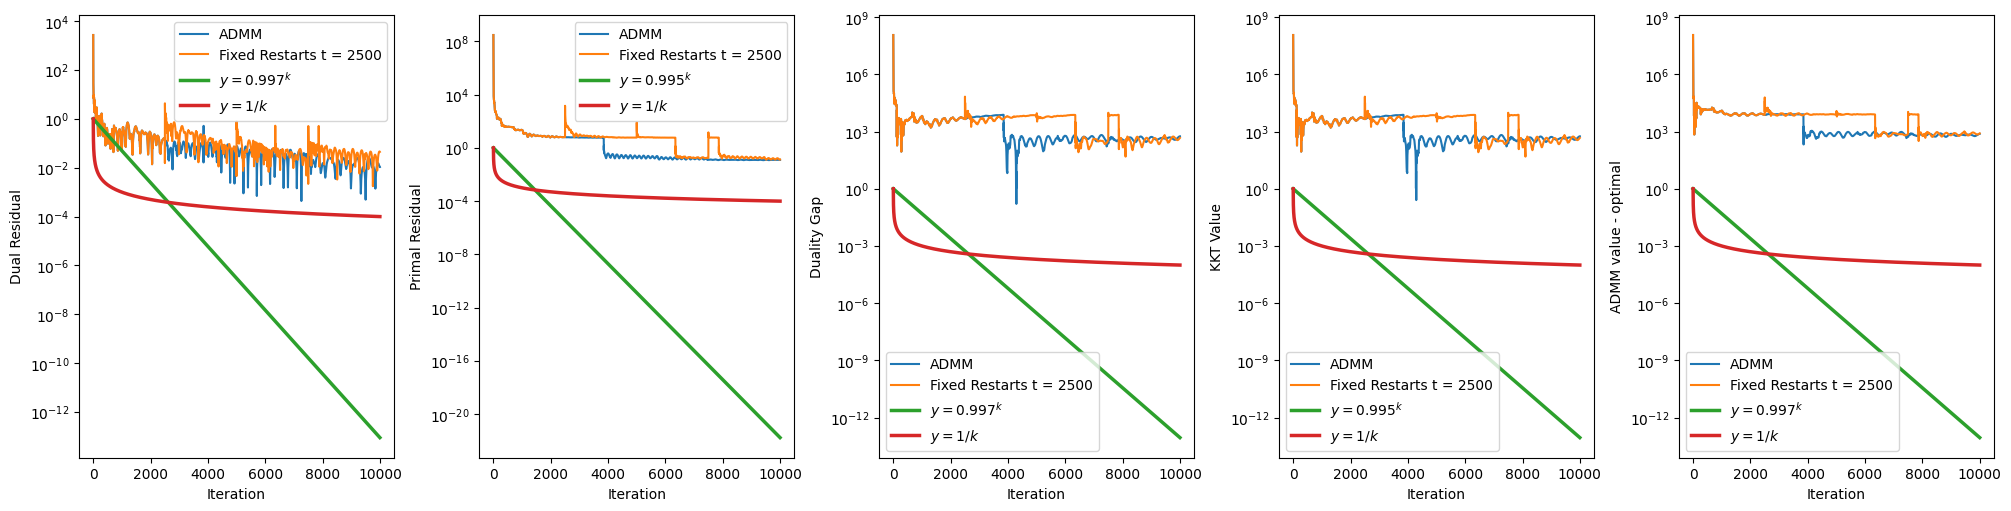

In [10]:
# NOTE
# ADMM + Fixed Restarts

np.random.seed(142)

value_ADMM_restarts_fixed = []
KKT_valus_rest_fixed = []
duality_gap_res_fixed = []
primal_residual_rest_fixed = []
dual_residual_rest_fixed = []

n = A_mat.shape[1]
m = A_mat.shape[0]

# Addign slack variables
A = np.vstack([A_mat, -np.eye(n)])

b = np.hstack([b_mat, np.zeros(n)])

c = c_mat

# Total iterations Number
iterations = 10000



x = np.zeros(n)
s = np.zeros(b.shape[0])
y = np.zeros(b.shape[0])
# NOTE Not sure if nu is the right value, just choose an argibrary one
rho = 0.3

# Implementing CVXPY to get the optimal values
x_cvxpy = cp.Variable(n)
s_cvxpy = cp.Variable(b.shape[0])
objective = cp.Minimize(c.T@x_cvxpy)
constraints = [A@x_cvxpy + s_cvxpy == b, s_cvxpy[m:] >= 0, s_cvxpy[:m] == 0]
problem = cp.Problem(objective, constraints)
problem.solve(solver=cp.CLARABEL, tol_gap_abs=1e-10, tol_gap_rel=1e-10,tol_feas=1e-10, tol_ktratio=1e-10)
print("Did cvxpy converge =", problem.status)
print("cvxpy value =", c.T @ x_cvxpy.value)

# z = np.zeros(500, dtype=object)
z = []
z_bar = 0

lu = splu(A.T @ A)

for f in [25, 50, 100, 150, 200, 400, 800, 1000, 1500, 2000, 2500]:

    # Initialize values
    count = 0
    x = np.zeros(n)
    s = np.zeros(b.shape[0])
    y = np.zeros(b.shape[0])
    
    value_ADMM_restarts_fixed = []
    KKT_valus_rest_fixed = []
    duality_gap_res_fixed = []
    primal_residual_rest_fixed = []
    dual_residual_rest_fixed = []
    
    z = []
    z_bar = 0
    
    # Outer loop
    for i in range(iterations):
        # Reset values
        z.append(z_bar)
        
        # Reseting the running average
        x_bar = 0
        s_bar = 0
        y_bar = 0
        
        t = 0
        
        # Inner loop
        for g in range(f):
            # xv_prev used for KKT
            x_prev = x
            
            # ADMM
            z_hat, z_admm = ADMM_new_mat(c, A, b, x, s, y, rho, n, m, lu)
            
            x = z_admm[0]
            s = z_admm[1]
            y = z_admm[2]

            value_ADMM_restarts_fixed.append(abs(c@x - problem.value))
            diff = abs(c@x - problem.value)

            x_bar = (t/(1+t)) * x_bar + (1/(1+t)) * z_hat[0]
            s_bar = (t/(1+t)) * s_bar + (1/(1+t)) * z_hat[1]
            y_bar = (t/(1+t)) * y_bar + (1/(1+t)) * z_hat[2]
            
            
            KKT = KKT_error_new_mat(rho, c, A, b, x, s, y, m, n)
            KKT_valus_rest_fixed.append(KKT)
            
            # Normal Duality Gap
            duality_gap_res_fixed.append(abs((b.T@y - c.T@x)))
            
            primal_residual_rest_fixed.append(np.linalg.norm(A@x + s - b)**2)
            
            # ADMM Dual Residual
            b_matrix = np.vstack([np.zeros((m,n)), np.eye(n)])
            
            # This is the dual feasibility violation
            dual_residual_rest_fixed.append(np.linalg.norm(np.minimum(c - (A.T+b_matrix.T) @ y, 0)))
            
            # Update count
            t += 1
            count += 1
                
            if count >= iterations:
                break
        if count >= iterations:
            print("For f =", f, f"we go over {iterations} iterations")
            break
        
        x = x_bar
        s = s_bar
        y = y_bar
        
        z_bar = [x, s, y]
    
    ADMM = [dual_residual, primal_residual, duality_gap, KKT_valus, value_ADMM]
    ADMM_custom = [dual_residual_rest_fixed, primal_residual_rest_fixed, duality_gap_res_fixed, KKT_valus_rest_fixed, value_ADMM_restarts_fixed]
    plot_results(ADMM, ADMM_custom, f'Fixed Restarts t = {f}')

print("count =", count)
print("ADMM with restarts value =", c.T @ x)